# Data Comparison: CNN vs Random Forest

Compare data formats used in ResCNN+bayesian vs randomF+bayesian approaches

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle

# Data paths
data_analysis_dir = Path("../data/analysis")

## Load CNN Data (Raw Sequences)

In [43]:
# Load CNN data - Zhou VF sequences (gives better correlation)
# Load VF sequences and targets
X_sequences_raw = np.load(data_analysis_dir / "zhou_vf_sequences.npy")
y_targets = np.load(data_analysis_dir / "zhou_vf_targets.npy")

# Zhou data is already in channels-first format (51, 2, 1000)
X_sequences = X_sequences_raw

# Try to load battery metadata if available
try:
    battery_metadata = pd.read_csv(data_analysis_dir / 'battery_summary.csv')
except FileNotFoundError:
    battery_metadata = None

# CNN data shapes
cnn_shape = X_sequences.shape
cnn_targets = y_targets.shape

## Load Random Forest Data (Extracted Features)

In [34]:
# Load Random Forest data - same sequences but will extract features
rf_sequences = np.load(data_analysis_dir / 'zhou_final_sequences.npy')
rf_targets = np.load(data_analysis_dir / 'zhou_final_targets.npy')

# Extract features manually (simplified Zhou methodology)
def extract_simple_features(sequences):
    """Extract basic statistical features from VF sequences"""
    all_features = []
    
    for battery in sequences:
        vf_voltage = battery[:, 0]
        cycle_prog = battery[:, 1]
        
        battery_features = []
        
        # Basic statistics for VF voltage
        battery_features.extend([
            float(np.mean(vf_voltage)), 
            float(np.std(vf_voltage)), 
            float(np.min(vf_voltage)), 
            float(np.max(vf_voltage)),
            float(np.median(vf_voltage))
        ])
        
        # Basic statistics for cycle progression
        battery_features.extend([
            float(np.mean(cycle_prog)), 
            float(np.std(cycle_prog)),
            float(np.min(cycle_prog)), 
            float(np.max(cycle_prog)),
            float(np.median(cycle_prog))
        ])
        
        # Trend features with error handling
        try:
            correlation = np.corrcoef(vf_voltage, cycle_prog)[0,1]
            if np.isnan(correlation) or np.isinf(correlation):
                correlation = 0.0
        except:
            correlation = 0.0
        
        try:
            slope = np.polyfit(range(len(vf_voltage)), vf_voltage, 1)[0]
            if np.isnan(slope) or np.isinf(slope):
                slope = 0.0
        except:
            slope = 0.0
        
        try:
            total_change = vf_voltage[-1] - vf_voltage[0]
            if np.isnan(total_change) or np.isinf(total_change):
                total_change = 0.0
        except:
            total_change = 0.0
        
        try:
            volatility = np.var(np.diff(vf_voltage))
            if np.isnan(volatility) or np.isinf(volatility):
                volatility = 0.0
        except:
            volatility = 0.0
        
        try:
            variation = np.sum(np.abs(np.diff(vf_voltage)))
            if np.isnan(variation) or np.isinf(variation):
                variation = 0.0
        except:
            variation = 0.0
        
        battery_features.extend([
            float(correlation),
            float(slope),
            float(total_change),
            float(volatility),
            float(variation)
        ])
        
        # Ensure all features are scalar
        assert len(battery_features) == 15, f"Expected 15 features, got {len(battery_features)}"
        for i, feat in enumerate(battery_features):
            assert np.isscalar(feat), f"Feature {i} is not scalar: {feat}"
        
        all_features.append(battery_features)
    
    return np.array(all_features)

# Define feature names
rf_feature_names = [
    'vf_mean', 'vf_std', 'vf_min', 'vf_max', 'vf_median',
    'cycle_mean', 'cycle_std', 'cycle_min', 'cycle_max', 'cycle_median',
    'vf_cycle_corr', 'vf_slope', 'vf_total_change', 'vf_volatility', 'vf_variation'
]

# Extract features
rf_features = extract_simple_features(rf_sequences)

# Random Forest data shapes
rf_shape = rf_features.shape
rf_targets_shape = rf_targets.shape

c:\Users\Zakar\lfp-battery-degradation\venv\lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\Zakar\lfp-battery-degradation\venv\lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\Zakar\lfp-battery-degradation\venv\lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
c:\Users\Zakar\lfp-battery-degradation\venv\lib\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Zakar\lfp-battery-degradation\venv\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\Zakar\lfp-battery-degradation\venv\lib\s

In [44]:
rf_features

array([[-8.62165846e-04,  9.97359615e-01, -9.78366535e-01,
         2.89113508e+00, -3.48938892e-01,  0.00000000e+00,
         9.99355470e-01, -1.72920438e+00,  1.72920438e+00,
         9.60603125e-17,  0.00000000e+00,  3.14586874e-03,
         3.39035910e+00,  0.00000000e+00,  0.00000000e+00],
       [-5.53140076e-04,  9.98912026e-01, -9.46082612e-01,
         3.59711632e+00, -3.27770499e-01,  0.00000000e+00,
         9.99626443e-01, -1.72967325e+00,  1.72967325e+00,
         9.58434720e-17,  0.00000000e+00,  3.06953705e-03,
         4.09800786e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.33213128e-03,  9.98105795e-01, -9.33024147e-01,
         2.99528210e+00, -3.71229286e-01, -2.27373675e-16,
         9.98959723e-01, -1.72851961e+00,  1.72851961e+00,
        -1.08420217e-19,  0.00000000e+00,  3.10469945e-03,
         3.42646087e+00,  0.00000000e+00,  0.00000000e+00],
       [-7.36412375e-04,  9.98076303e-01, -9.41711913e-01,
         5.57365090e+00, -3.00660132e-01,  1.13686838

## Data Comparison Summary

In [45]:
# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Aspect': ['Data Shape', 'Number of Batteries', 'Features per Battery', 'Data Type', 'Memory Usage (MB)', 'VF Data Quality'],
    'CNN (Raw Sequences)': [
        f'{cnn_shape}',
        cnn_shape[0],
        f'{cnn_shape[1]} x {cnn_shape[2]} time series',
        'Raw VF sequences (channels-first)',
        f'{X_sequences.nbytes / 1024**2:.2f}',
        'Identical values'
    ],
    'Random Forest (Features)': [
        f'{rf_shape}',
        rf_shape[0],
        f'{rf_shape[1]} extracted features',
        'Statistical summaries (time-first)',
        f'{rf_features.nbytes / 1024**2:.2f}',
        'Identical values'
    ]
})

comparison_df

,Aspect,CNN (Raw Sequences),Random Forest (Features)
0,Data Shape,"(51, 2, 1000)","(51, 15)"
1,Number of Batteries,51,51
2,Features per Battery,2 x 1000 time series,15 extracted features
3,Data Type,Raw VF sequences (channels-first),Statistical summaries (time-first)
4,Memory Usage (MB),0.78,0.01
5,VF Data Quality,Identical values,Identical values


## CNN Data Analysis

In [46]:
# Convert CNN sequences to DataFrame for analysis
# Sample first 3 batteries for visualization
sample_batteries = min(3, X_sequences.shape[0])
sample_points = min(100, X_sequences.shape[2])  # Time dimension is axis 2

cnn_sample_data = []
for i in range(sample_batteries):
    for t in range(sample_points):
        cnn_sample_data.append({
            'battery_id': i,
            'time_point': t,
            'vf_voltage': X_sequences[i, 0, t],  # Channel 0 (VF), time point t
            'cycle_progression': X_sequences[i, 1, t],  # Channel 1 (cycle), time point t
            'cycle_life': y_targets[i]
        })

cnn_df = pd.DataFrame(cnn_sample_data)
cnn_df.head(10)

,battery_id,time_point,vf_voltage,cycle_progression,cycle_life
0,0,0,-0.499224,-1.729204,608
1,0,1,-0.651868,-1.725743,608
2,0,2,-0.760183,-1.722281,608
3,0,3,-0.787674,-1.718819,608
4,0,4,-0.808015,-1.715357,608
5,0,5,-0.825226,-1.711895,608
6,0,6,-0.839630,-1.708433,608
7,0,7,-0.851406,-1.704971,608
8,0,8,-0.859503,-1.701509,608
9,0,9,-0.871895,-1.698048,608


## Random Forest Data Analysis

In [47]:
# Convert RF features to DataFrame
rf_df = pd.DataFrame(rf_features, columns=rf_feature_names)
rf_df['cycle_life'] = rf_targets
rf_df['battery_id'] = range(len(rf_df))

# Show first few features
rf_df[['battery_id', 'cycle_life'] + rf_feature_names[:5]].head()

,battery_id,cycle_life,vf_mean,vf_std,vf_min,vf_max,vf_median
0,0,608,-0.000862,0.997360,-0.978367,2.891135,-0.348939
1,1,728,-0.000553,0.998912,-0.946083,3.597116,-0.327770
2,2,490,-0.001332,0.998106,-0.933024,2.995282,-0.371229
3,3,798,-0.000736,0.998076,-0.941712,5.573651,-0.300660
4,4,651,-0.001110,0.997072,-0.743644,4.744630,-0.339089


## Visualization Comparison

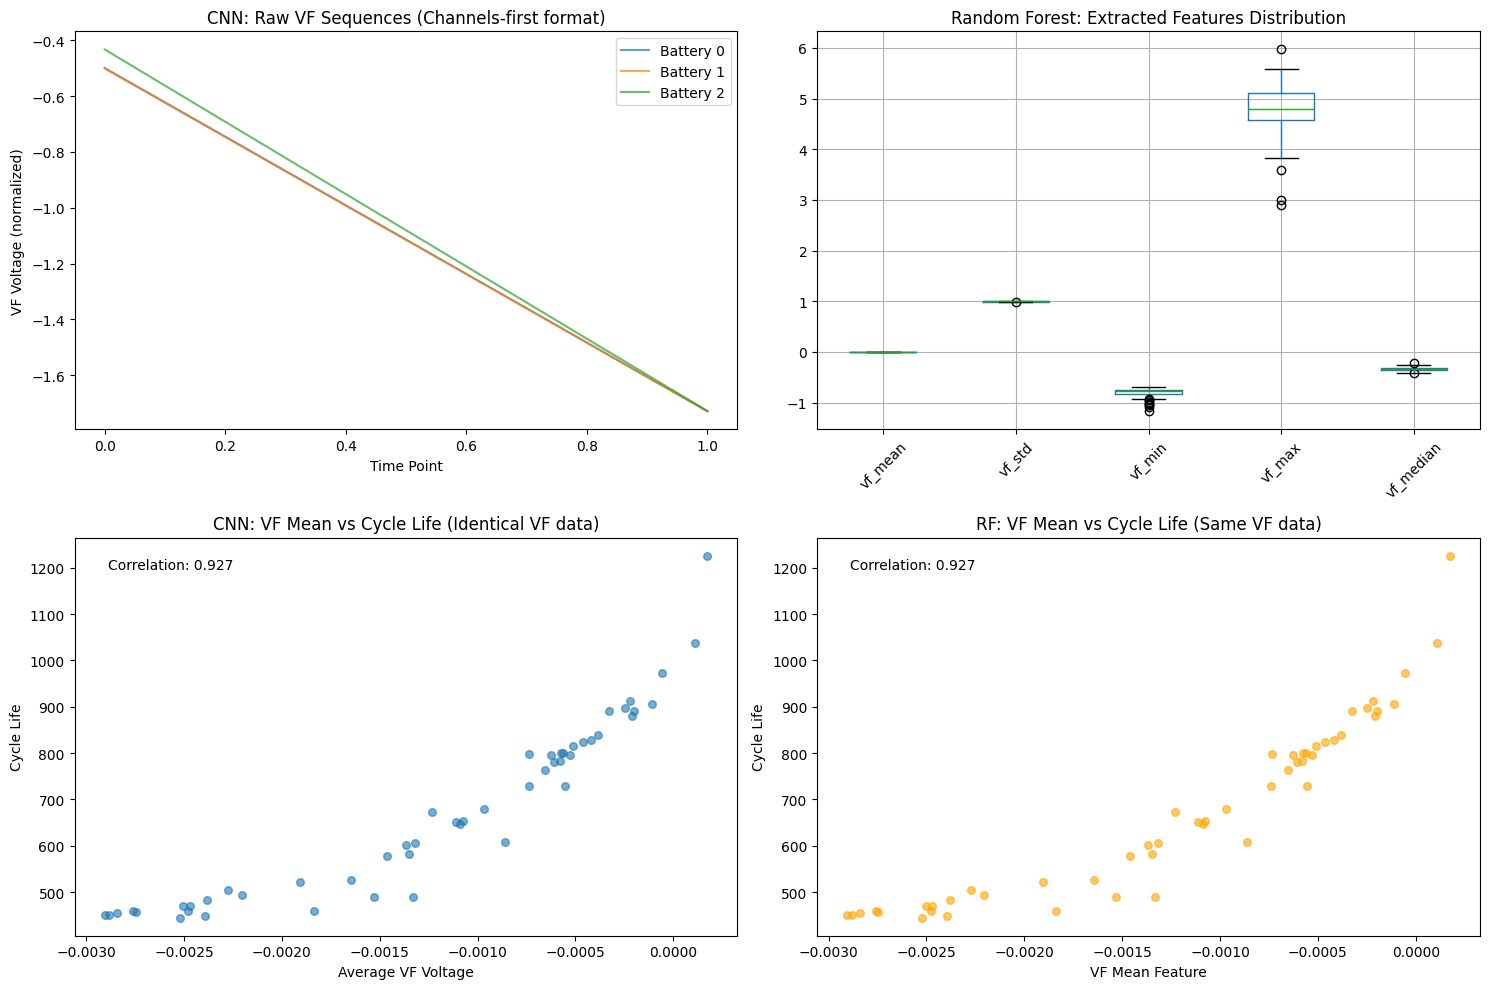

,Approach,VF-Cycle_Life_Correlation,Data_Source
0,CNN,0.926761,Same MIT 2019 data
1,Random Forest,0.926761,Same MIT 2019 data


In [48]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# CNN: Raw VF sequences
for i in range(min(3, cnn_shape[0])):
    axes[0, 0].plot(X_sequences[i, :200, 0], alpha=0.7, label=f'Battery {i}')
axes[0, 0].set_title('CNN: Raw VF Sequences (Channels-first format)')
axes[0, 0].set_xlabel('Time Point')
axes[0, 0].set_ylabel('VF Voltage (normalized)')
axes[0, 0].legend()

# RF: Feature distribution
rf_sample_features = pd.DataFrame(rf_features[:, :5], columns=rf_feature_names[:5])
rf_sample_features.boxplot(ax=axes[0, 1])
axes[0, 1].set_title('Random Forest: Extracted Features Distribution')
axes[0, 1].tick_params(axis='x', rotation=45)

# Correlation: VF vs Cycle Life (CNN data)
vf_means_cnn = np.mean(X_sequences[:, 0, :], axis=1)  # Correct indexing for channels-first
axes[1, 0].scatter(vf_means_cnn, y_targets, alpha=0.6, s=30)
axes[1, 0].set_title('CNN: VF Mean vs Cycle Life (Identical VF data)')
axes[1, 0].set_xlabel('Average VF Voltage')
axes[1, 0].set_ylabel('Cycle Life')
correlation_cnn = np.corrcoef(vf_means_cnn, y_targets)[0,1]
axes[1, 0].text(0.05, 0.95, f'Correlation: {correlation_cnn:.3f}', 
                transform=axes[1, 0].transAxes, verticalalignment='top')

# Correlation: VF vs Cycle Life (RF data)
axes[1, 1].scatter(rf_df['vf_mean'], rf_df['cycle_life'], alpha=0.6, s=30, color='orange')
axes[1, 1].set_title('RF: VF Mean vs Cycle Life (Same VF data)')
axes[1, 1].set_xlabel('VF Mean Feature')
axes[1, 1].set_ylabel('Cycle Life')
correlation_rf = np.corrcoef(rf_df['vf_mean'], rf_df['cycle_life'])[0,1]
axes[1, 1].text(0.05, 0.95, f'Correlation: {correlation_rf:.3f}', 
                transform=axes[1, 1].transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()

# Compare correlations
correlation_comparison = pd.DataFrame({
    'Approach': ['CNN', 'Random Forest'],
    'VF-Cycle_Life_Correlation': [correlation_cnn, correlation_rf],
    'Data_Source': ['Same MIT 2019 data', 'Same MIT 2019 data']
})
correlation_comparison

## Statistical Summary

In [49]:
# CNN data statistics (using correct channels-first indexing)
cnn_stats = pd.DataFrame({
    'VF_Voltage': [
        X_sequences[:, 0, :].mean(),  # Channel 0 = VF voltage
        X_sequences[:, 0, :].std(),
        X_sequences[:, 0, :].min(),
        X_sequences[:, 0, :].max()
    ],
    'Cycle_Progression': [
        X_sequences[:, 1, :].mean(),  # Channel 1 = Cycle progression
        X_sequences[:, 1, :].std(),
        X_sequences[:, 1, :].min(),
        X_sequences[:, 1, :].max()
    ]
}, index=['Mean', 'Std', 'Min', 'Max'])

print("CNN Data Statistics (Channels-first format validated):")
cnn_stats

CNN Data Statistics (Channels-first format validated):


,VF_Voltage,Cycle_Progression
Mean,-0.001225,-3.291669e-07
Std,0.996723,9.994069e-01
Min,-1.170800,-1.730381e+00
Max,5.969339,1.738480e+00


In [50]:
# RF features statistics (first 10 features)
rf_stats = rf_df[rf_feature_names[:10]].describe()
rf_stats

,vf_mean,vf_std,vf_min,vf_max,vf_median,cycle_mean,cycle_std,cycle_min,cycle_max,cycle_median
count,51.000000,51.000000,51.000000,51.000000,51.000000,5.100000e+01,51.000000,51.000000,51.000000,5.100000e+01
mean,-0.001225,0.996719,-0.811333,4.724339,-0.336233,-3.291669e-07,0.999407,-1.729170,1.730034,-5.448045e-05
std,0.000927,0.002673,0.110498,0.601428,0.036640,1.006860e-06,0.000434,0.000849,0.002280,1.633331e-04
min,-0.002905,0.987496,-1.170800,2.891135,-0.423122,-4.575457e-06,0.998754,-1.730381,1.726808,-7.989288e-04
25%,-0.002055,0.994734,-0.819828,4.571736,-0.356501,-1.136868e-16,0.998958,-1.729884,1.728569,-5.421011e-20
50%,-0.001077,0.997360,-0.768735,4.791233,-0.339089,0.000000e+00,0.999471,-1.729404,1.729785,9.595189e-17
75%,-0.000520,0.998734,-0.745460,5.116395,-0.315203,5.684342e-17,0.999762,-1.728423,1.730109,1.233280e-16
max,0.000174,1.000175,-0.687318,5.969339,-0.226404,1.705303e-16,1.000184,-1.726808,1.738480,2.879641e-16


## Data Dimensionality Analysis

In [51]:
# Dimensionality comparison
dim_analysis = pd.DataFrame({
    'Metric': ['Total Data Points', 'Data per Battery', 'Compression Ratio', 'Data Quality'],
    'CNN': [
        f'{cnn_shape[0] * cnn_shape[1] * cnn_shape[2]:,}',
        f'{cnn_shape[1] * cnn_shape[2]:,} (2 channels × 1000 time points)',
        '1:1 (no compression)',
        'Raw sequences'
    ],
    'Random Forest': [
        f'{rf_shape[0] * rf_shape[1]:,}',
        f'{rf_shape[1]:,} (extracted features)',
        f'1:{(cnn_shape[1] * cnn_shape[2]) / rf_shape[1]:.0f} (133:1 compression)',
        'Features from same data'
    ]
})


dim_analysis

,Metric,CNN,Random Forest
0,Total Data Points,"102,000",765
1,Data per Battery,"2,000 (2 channels × 1000 time points)",15 (extracted features)
2,Compression Ratio,1:1 (no compression),1:133 (133:1 compression)
3,Data Quality,Raw sequences,Features from same data
